<a href="https://colab.research.google.com/github/hsnam95/my/blob/main/Sentiment%20Analysis(Harry%20Potter).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Sentiment Analysis

Bring in text data from source:

In [10]:
!git clone https://github.com/ErikaJacobs/Harry-Potter-Text-Mining.git

fatal: destination path 'Harry-Potter-Text-Mining' already exists and is not an empty directory.


In [ ]:
import pandas as pd #Importing Pandas package
%cd /content/Harry-Potter-Text-Mining/Book Text

import glob 
fns = glob.glob('*.txt')
df = pd.DataFrame()
for fn in fns:
  dftmp = pd.read_csv(fn, sep="@")
  df = pd.concat([df, dftmp])

%cd /content

In [13]:
df.head(200)

,Text,Chapter,Book
0,The villagers of Little Hangleron still call...,1,4
1,"Harry lay flat on his back, breathing hard a...",2,4
2,"By the time Harry arrived in the kitchen, th...",3,4
3,"By twelve o'clock the next day, Harry's scho...",4,4
4,"Harry spun faster and faster, elbows tucked ...",5,4
...,...,...,...
25,Harry could smell salt and hear rushing waves...,26,6
26,"Once back under the starry sky, Harry heaved ...",27,6
27,Harry felt as though he too were hurtling thr...,28,6
28,"Come here, Harry ...\ \""No.\"" \""Yeh can' stay...",29,6


In [14]:
import nltk #Import NLTK library
nltk.download('stopwords')
nltk.download('punkt') #installed punkt to fix error
from nltk import word_tokenize
from nltk.corpus import stopwords #Import stopwords to Python

stopwords = set(stopwords.words('english')) #English stopwords assigned to "stopwords" object

import string #Punctuation

# Function for removing punctuation
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

stopwords = [''.join(item for item in x if item not in string.punctuation) for x in stopwords] #Remove punctuation from stopwords

df['WordCountText']=df['Text'].str.lower().apply(remove_punctuations).apply(word_tokenize) # Word Count Text
# Word Count
df['WordCloudText']=df['WordCountText'].apply(lambda x: [word for word in x if word not in stopwords]) # Word Cloud Text
df['WordCount'] = df['WordCountText'].str.len() #Word Count Per Chapter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [15]:
# Creating a table breaking down the text by each sentence, rather than each chapter.
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.stem import PorterStemmer

# Make smaller table - reset index to prepare for further work
dfsentiment = df[['Book','Chapter','Text']].reset_index() \
    .drop(["index"], axis=1)
dfsentiment = dfsentiment.join(dfsentiment.Text.apply(sent_tokenize).rename('Sentences')) # Breaking apart text into sentences

#Put every tokenized sentence into its own row
dfsentiment2 = dfsentiment.Sentences.apply(pd.Series) \
    .merge(dfsentiment, left_index = True, right_index = True) \
    .drop(["Text"], axis = 1) \
    .drop(["Sentences"], axis = 1) \
    .melt(id_vars = ['Book', 'Chapter'], value_name = "Sentence") \
    .drop("variable", axis = 1) \
    .dropna()

# Sort new table by Book and Chapter - reset index to reflect new order
dfsentiment2=dfsentiment2.sort_values(by=['Book', 'Chapter']) \
    .reset_index() \
    .drop(['index'], axis = 1)

# Clean punctuation, lower case
dfsentiment2['Sentence']=dfsentiment2.Sentence.apply(remove_punctuations).apply(lambda x: x.lower()) \

# Check first five values
dfsentiment2

,Book,Chapter,Sentence
0,1,1,the boy who lived mr and mrs dursley of numbe...
1,1,1,they were the last people youd expect to be in...
2,1,1,mr dursley was the director of a firm called g...
3,1,1,he was a big beefy man with hardly any neck al...
4,1,1,mrs dursley was thin and blonde and had nearly...
...,...,...,...
70979,7,37,the train began to more and harry walked along...
70980,7,37,harry kept smiling and waving even though it w...
70981,7,37,the train rounded a corner
70982,7,37,harrys hand was still raised in farewellhell b...


In [16]:
# 71,016 rows in sentiment2 according to the table created
# Check that there are 71,016 sentences before stacking rows

dfsentiment.Sentences.apply(lambda x: len(x)).sum() # Count total sentences

70984

In [17]:
# Bring in VADER library and Sentiment Intensity Analyzer

from nltk.sentiment.vader import SentimentIntensityAnalyzer

import nltk
nltk.download('vader_lexicon')

sid=nltk.sentiment.vader.SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [18]:
# Get intensity scores of each sentence
dfsentiment2['Score']=dfsentiment2.Sentence.apply(lambda x: sid.polarity_scores(x))

# Place scores in own columns
dfsentiment2['CompScore']=dfsentiment2.Score.apply(lambda x: x.get("compound"))
dfsentiment2['PosScore']=dfsentiment2.Score.apply(lambda x: x.get("pos"))
dfsentiment2['NegScore']=dfsentiment2.Score.apply(lambda x: x.get("neg"))
dfsentiment2['NeuScore']=dfsentiment2.Score.apply(lambda x: x.get("neu"))

# With scores extracted, the original score field can be removed
dfsentiment2 = dfsentiment2.drop(["Score"], axis=1)

# Adding Sentiment Flags
dfsentiment2['PosFlag'] = dfsentiment2.CompScore.apply(lambda x: 1 if x >= 0.05 else 0)
dfsentiment2['NegFlag'] = dfsentiment2.CompScore.apply(lambda x: 1 if x <= -0.05 else 0)
dfsentiment2['NeuFlag'] = dfsentiment2.CompScore.apply(lambda x: 1 if x < 0.05 and x > -0.05 else 0)

In [ ]:
# Confirm scores are present and flag is functional
dfsentiment2.head(20)

,Book,Chapter,Sentence,CompScore,PosScore,NegScore,NeuScore,PosFlag,NegFlag,NeuFlag
0,1,1,the boy who lived mr and mrs dursley of numbe...,0.8779,0.335,0.000,0.665,1,0,0
1,1,1,they were the last people youd expect to be in...,-0.5423,0.000,0.176,0.824,0,1,0
2,1,1,mr dursley was the director of a firm called g...,0.0000,0.000,0.000,1.000,0,0,1
3,1,1,he was a big beefy man with hardly any neck al...,0.0000,0.000,0.000,1.000,0,0,1
4,1,1,mrs dursley was thin and blonde and had nearly...,0.4927,0.084,0.000,0.916,1,0,0
5,1,1,the dursleys had a small son called dudley and...,-0.2960,0.000,0.121,0.879,0,1,0
6,1,1,the dursleys had everything they wanted but th...,0.3612,0.199,0.148,0.653,1,0,0
7,1,1,they didnt think they could bear it if anyone ...,0.0000,0.000,0.000,1.000,0,0,1
8,1,1,mrs potter was mrs dursleys sister but they ha...,0.0000,0.000,0.000,1.000,0,0,1
9,1,1,the dursleys shuddered to think what the neigh...,0.0000,0.000,0.000,1.000,0,0,1


In [ ]:
dfsentiment2.iloc[66771].Sentence

'he was drenched in sweat he could feel it on the sheets and blanketswe got awayyes said hermione'

In [ ]:
dfsentiment2.groupby('Book').mean()['CompScore']

Book
1    0.019829
2    0.002223
3    0.005590
4    0.012213
5    0.007200
6    0.024172
7   -0.031744
Name: CompScore, dtype: float64

In [ ]:
print('There are', dfsentiment2['PosFlag'].sum(), "positive sentences,", \
      dfsentiment2['NegFlag'].sum(), "negative sentences, and", \
      dfsentiment2['NeuFlag'].sum(), "neutral sentences")
print('This is a total of', \
      dfsentiment2['PosFlag'].sum()+dfsentiment2['NegFlag'].sum()+dfsentiment2['NeuFlag'].sum(), "sentences")

There are 19055 positive sentences, 18385 negative sentences, and 33544 neutral sentences
This is a total of 70984 sentences


<ipython-input-38-4ef2b361b4b8>:31: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  dfsentiment2.groupby(['Chapter','BookTitle']).mean()['CompScore'].unstack().plot(ax=ax, subplots=True, ylim=(-0.25, 0.25), colormap=ColorMap)


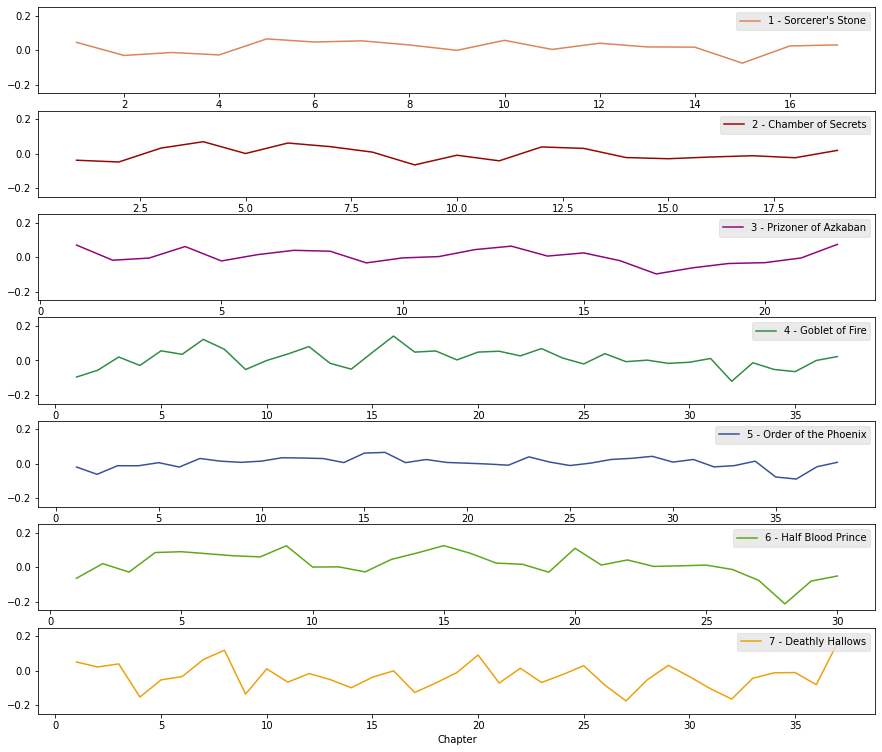

In [ ]:
# How does the sentiment change during each chapter of each book over time?

def Titles(x):
    if x == 1:
        return "1 - Sorcerer's Stone"
    if x == 2:
        return "2 - Chamber of Secrets"
    if x == 3:
        return "3 - Prizoner of Azkaban"
    if x == 4:
        return "4 - Goblet of Fire"
    if x == 5:
        return "5 - Order of the Phoenix"
    if x == 6:
        return "6 - Half Blood Prince"
    if x == 7:
        return "7 - Deathly Hallows"

dfsentiment2['BookTitle']=dfsentiment2.Book.apply(lambda x: Titles(x))

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

colorsList = ['#DC8458', '#950702', '#8E067D', '#2E8C44', '#395196', '#60A619','#ECA10A'] #Mauraders Map Colors
ColorMap = matplotlib.colors.ListedColormap(colorsList)

# plot data
fig, ax = plt.subplots(figsize=(15,13))
# use unstack()
dfsentiment2.groupby(['Chapter','BookTitle']).mean()['CompScore'].unstack().plot(ax=ax, subplots=True, ylim=(-0.25, 0.25), colormap=ColorMap)
plt.style.use('ggplot')
ax.set_ylabel('Compound Sentiment Score')

[ax.legend(loc=1) for ax in plt.gcf().axes]

plt.savefig('./HPTimeplot.png')